# Mindaugas Sarskus
## G00339629
Git repo on [GitLab](https://gitlab.com/My-/mnist-emerging-technologies)

### Imports

In [1]:
import gzip
from subprocess import check_output # run comands in terminal
print(check_output(['uname', '-mrs']).decode('utf8'))

import keras as kr
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2
print('keras version: '+ kr.__version__)

import numpy as np  # linear algebra
print('numpy version: '+ np.version.version)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print('pandas version: '+ pd.__version__)

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib version: '+ matplotlib.__version__)
%matplotlib inline


Linux 4.15.0-66-generic x86_64



Using TensorFlow backend.


keras version: 2.2.4
numpy version: 1.16.4
pandas version: 0.25.0
matplotlib version: 3.1.1


### Global variables

In [2]:
epochs = 10
lable_classes = 10
img_rows, img_cols = 28, 28

# directory were files are located
data_directory = 'data/'
# http://yann.lecun.com/exdb/mnist/
t10k_data_file = 't10k-images-idx3-ubyte.gz'
t10k_lable_file = 't10k-labels-idx1-ubyte.gz'
t60k_data_file = 'train-images-idx3-ubyte.gz'
t60k_lable_file = 'train-labels-idx1-ubyte.gz'

# print data directory content
print(check_output(['ls', data_directory]).decode('utf8'))

t10k-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz
train-images-idx3-ubyte.gz
train-labels-idx1-ubyte.gz



## Read data from files

In [3]:
# Adapted from: https://docs.python.org/3/library/gzip.html

# Read training data
# 10k
with gzip.open(data_directory + t10k_data_file, 'rb') as f:
    t10k_data_bytes = f.read()
    
# 60k
with gzip.open(data_directory + t60k_data_file, 'rb') as f:
    t60k_data_bytes = f.read()    
    
# Read lables
# 10k
with gzip.open(data_directory + t10k_lable_file, 'rb') as f:
    t10k_labels_bytes = f.read()
    
# 60k
with gzip.open(data_directory + t60k_lable_file, 'rb') as f:
    t60k_labels_bytes = f.read()
    
# check type
print(type(t10k_data_bytes))

<class 'bytes'>


### Reshape data

In [4]:
# For the image data skip first 16 file meta bytes 
# Then create 2d array of images (28x28 pixel)
t10k_data = ~np.array(list(t10k_data_bytes[16:]))
t10k_data = t10k_data.reshape(10000, img_rows, img_cols, 1) # reshape to [number-of-img, row, col, values-per-pixel]
t10k_data = kr.utils.normalize(t10k_data, axis=1)
# same as:
# t10k_data = t10k_data.astype('float32')
# t10k_data /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
print(t10k_data.shape)

t60k_data = ~np.array(list(t60k_data_bytes[16:]))
t60k_data = t60k_data.reshape(60000, img_rows, img_cols, 1)
t60k_data = kr.utils.normalize(t60k_data, axis=1)
print(t60k_data.shape)


print(type(t10k_data))

(10000, 28, 28, 1)
(60000, 28, 28, 1)
<class 'numpy.ndarray'>


In [5]:
# For the lable data skip first 8 file meta bytes
t10k_labels = np.array(list(t10k_labels_bytes[8:])).astype(np.uint8)
t60k_labels = np.array(list(t60k_labels_bytes[8:])).astype(np.uint8)

print(t10k_labels.shape)
print(type(t10k_labels[0]))
print(t10k_labels[0])

(10000,)
<class 'numpy.uint8'>
7


### Inspect data


7 2 1 0 4 1 4 9 5 9 

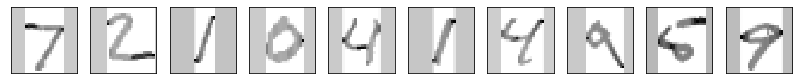

In [6]:
# adapted from: https://www.ics.uci.edu/~mohamadt/keras_mnist.html
plt.figure(1, figsize=(14,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(t10k_data[i].reshape(28,28), cmap='gray', interpolation='nearest')     
    # remove plot marking
    plt.xticks([])
    plt.yticks([])
    
for i in range(10):
    print(t10k_labels[i], end=" ")

In [7]:
# Converting lables to one-hot vectors:
#    1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
#    2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
#    ...

t10k_label_vec = np_utils.to_categorical(t10k_labels, lable_classes)
t60k_label_vec = np_utils.to_categorical(t60k_labels, lable_classes)

for i in range(10):
    print(t10k_labels[i], end=" -> ")
    print(t10k_label_vec[i])

7 -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Building neural network

In [8]:

input_shape = (img_rows, img_cols, 1)
# cnn
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(lable_classes, activation='softmax'))

W1102 22:45:29.868827 140187476309824 deprecation_wrapper.py:119] From /root/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1102 22:45:29.885539 140187476309824 deprecation_wrapper.py:119] From /root/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1102 22:45:29.888452 140187476309824 deprecation_wrapper.py:119] From /root/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1102 22:45:29.913993 140187476309824 deprecation_wrapper.py:119] From /root/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1102 22

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

In [10]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

W1102 22:45:30.312707 140187476309824 deprecation_wrapper.py:119] From /root/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [11]:
history = model.fit(
    t60k_data, 
    t60k_label_vec, 
    batch_size=128, 
    epochs=12,#epochs, 
#     validation_split=0.2, # how much data leave for validation
    shuffle=True, # shufle data
    verbose=1,                    
    validation_data=(t10k_data, t10k_label_vec)
)

W1102 22:45:30.432521 140187476309824 deprecation.py:323] From /root/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 134s 2ms/step - loss: 0.1144 - acc: 0.9665 - val_loss: 0.0581 - val_acc: 0.9817
Epoch 2/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0333 - acc: 0.9903 - val_loss: 0.0444 - val_acc: 0.9860
Epoch 3/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0170 - acc: 0.9952 - val_loss: 0.0362 - val_acc: 0.9884
Epoch 4/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0105 - acc: 0.9973 - val_loss: 0.0325 - val_acc: 0.9891
Epoch 5/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0084 - acc: 0.9976 - val_loss: 0.0366 - val_acc: 0.9892
Epoch 6/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0056 - acc: 0.9984 - val_loss: 0.0396 - val_acc: 0.9879
Epoch 7/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.0464 - 

In [12]:
score = model.evaluate(t10k_data, t10k_label_vec, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.029832000615039943
Test accuracy: 0.9918


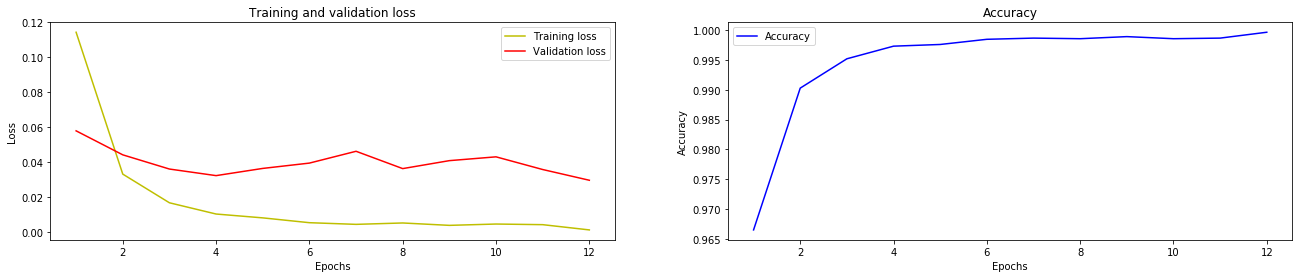

In [13]:
# adopted from: https://towardsdatascience.com/backpropagation-and-batch-normalization-in-feedforward-neural-networks-explained-901fd6e5393e

acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')


plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()

plt.subplot(1, 2, 2)

plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplots_adjust( right=3)
plt.legend()
plt.show()


In [15]:
model.save('cnn-bn-9918-12e.model')